# Explainer

---

## Load Data Split

In [4]:
import pandas as pd

X_train = pd.read_csv("../CICIDS2017/train_test_split/X_train_proto.csv")
X_test = pd.read_csv("../CICIDS2017/train_test_split/X_test_proto.csv")
y_train = pd.read_csv("../CICIDS2017/train_test_split/y_train_proto.csv")
y_test = pd.read_csv("../CICIDS2017/train_test_split/y_test_proto.csv")

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 70) (2000, 70) (8000, 2) (2000, 2)


## Import Model

In [5]:
# load model
from tensorflow import keras

model = keras.models.load_model('../CICIDS2017/models/ids_dnn.keras')
model.summary()

2025-01-21 11:38:52.705128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737455932.723218   68062 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737455932.728574   68062 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 11:38:52.746992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-21 11:38:55.274324: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │         3,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,238 (63.43 KB)

 Trainable params: 5,412 (21.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,826 (42.29 KB)

## Extract SHAP Values

In [6]:
# extract SHAP values
import shap
import numpy as np

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_test, feature_names=X_test.columns)
shap_values = explainer(X_test)

print(shap_values.shape)

PermutationExplainer explainer: 2001it [02:08, 14.67it/s]                          


(2000, 70, 2)


In [7]:
# convert shap values to correct format
print(shap_values.shape) # one shap value per feature per sample per class
shap_values = shap_values[:, :, 0] # 1 == Benign, 0 == Malicious
print(shap_values.shape) # one shap value per feature per sample

(2000, 70, 2)
(2000, 70)


## Store SHAP Values

In [8]:
# convert shap values to dataframe
feature_names = explainer.feature_names

shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
print(shap_df.shape)

(2000, 70)


In [9]:
# store shap_df
shap_df.to_csv("../CICIDS2017/shap_values/shap_values_proto.csv", index=False)

## Plot SHAP Values

### Local Models

#### Benign Class

0


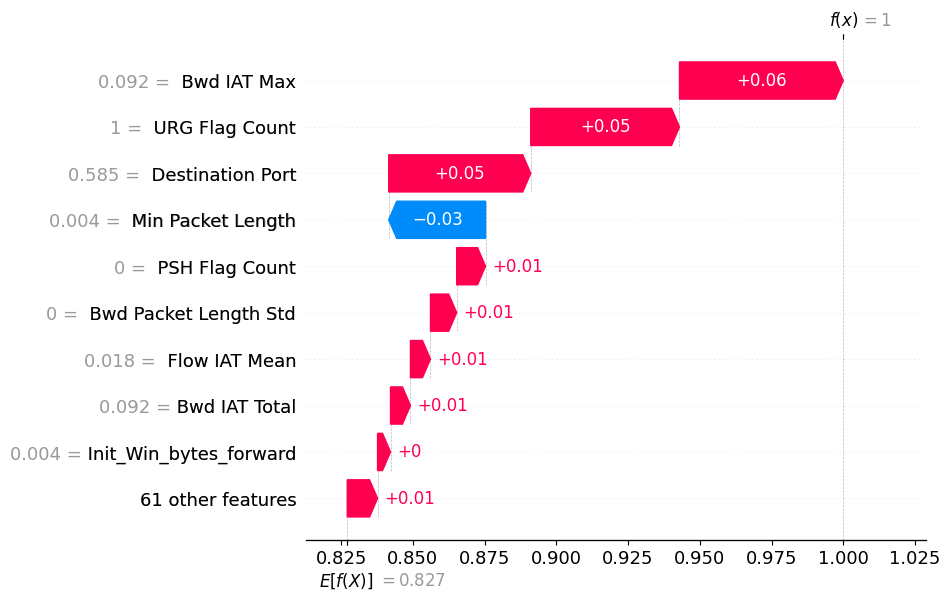

In [10]:
# plot explanations from bengin class
benign_classes = np.array(y_test[y_test['BENIGN'] == 1].index)
first_benign_index = benign_classes[0]
print(first_benign_index)
shap.waterfall_plot(shap_values[first_benign_index])

#### Malicious Class

9


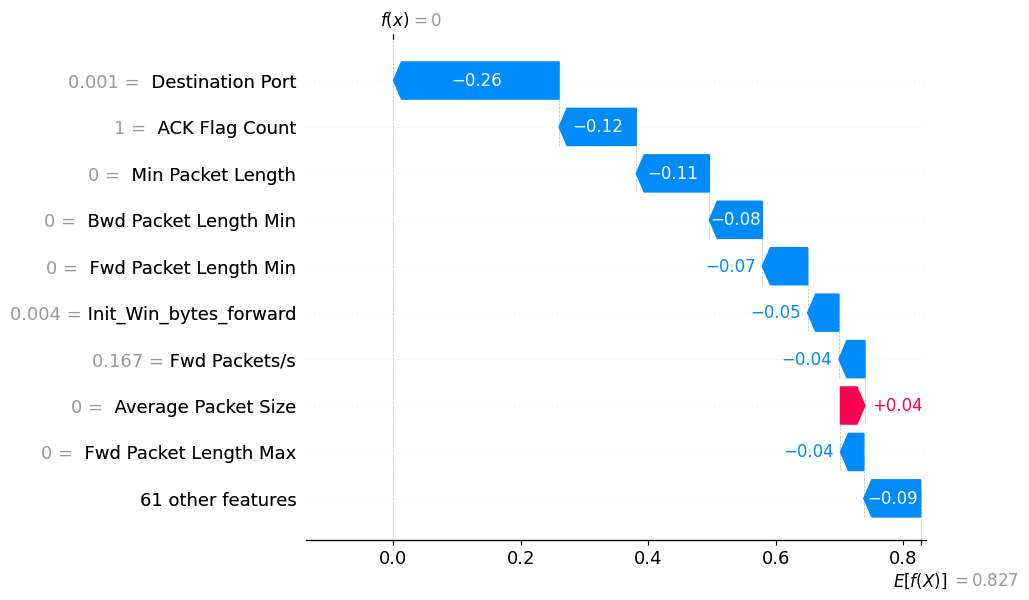

In [11]:
# plot explanations from malicious class
malicious_classes = np.array(y_test[y_test['MALICIOUS'] == 1].index)
first_malicious_index = malicious_classes[0]
print(first_malicious_index)
shap.waterfall_plot(shap_values[first_malicious_index])

### Global Models

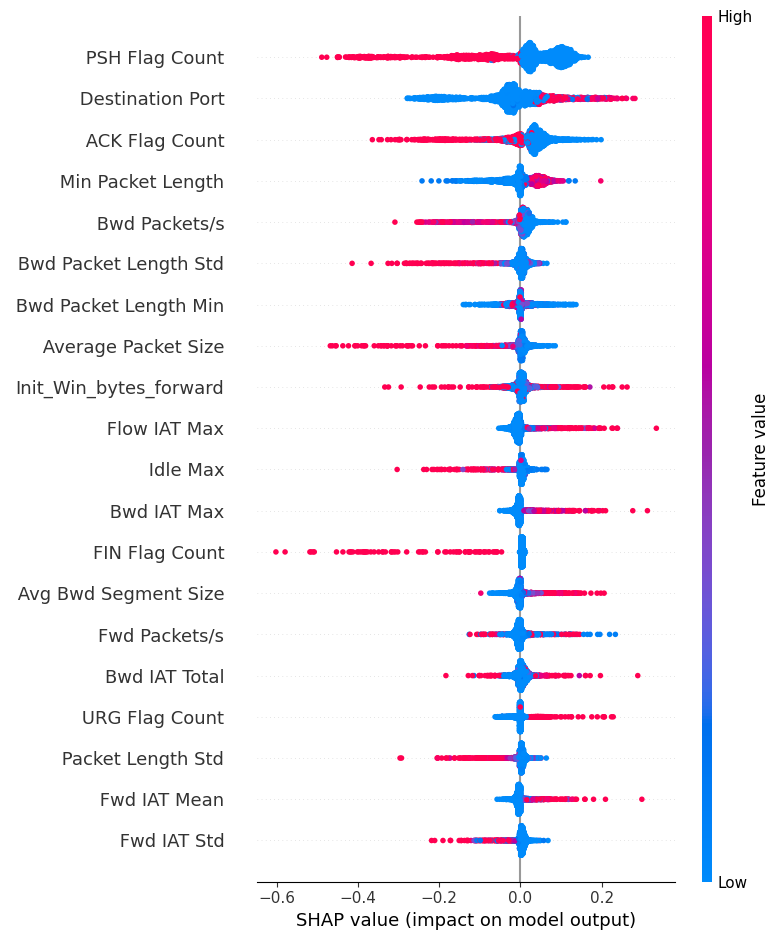

In [12]:
# summary plot
shap.summary_plot(shap_values, X_test)

#### Mean SHAP Values for Benign Class

Shap values shape: (2000, 70)
Benign classes shape: (1619,)
Benign shape values shape: (1619, 70)


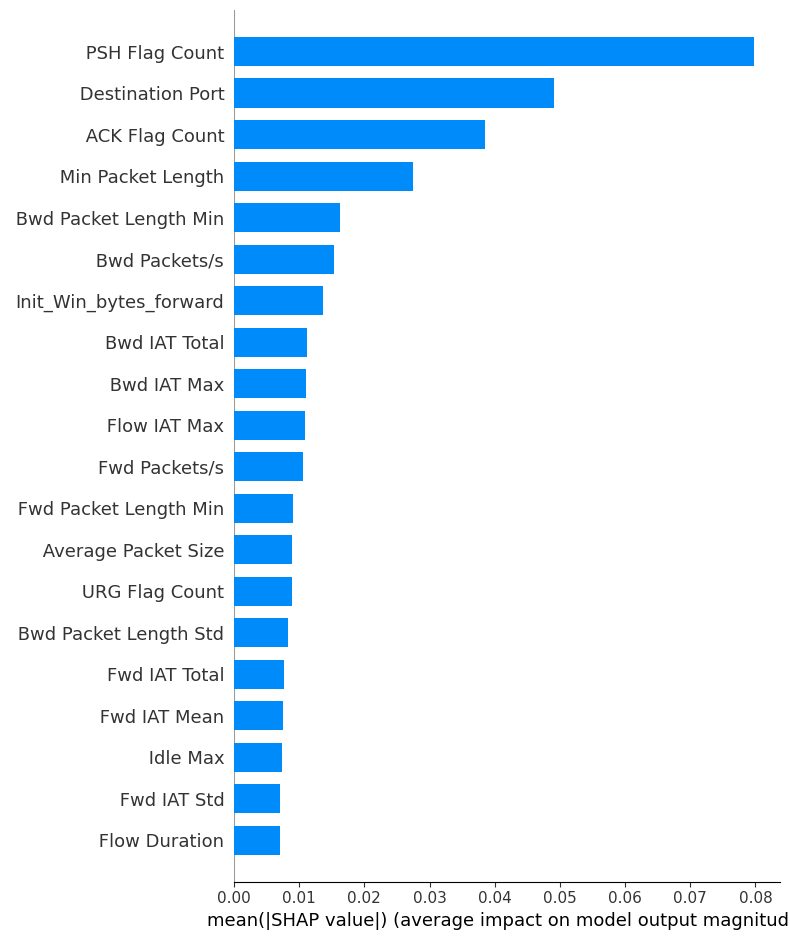

In [13]:
print(f"Shap values shape: {shap_values.shape}")
print(f"Benign classes shape: {benign_classes.shape}")

benign_shape_values = shap_values[benign_classes]
print(f"Benign shape values shape: {benign_shape_values.shape}")
shap.summary_plot(benign_shape_values, X_train, plot_type="bar")


#### MEAN SHAP Values for Malicious Class

Shap values shape: (2000, 70)
Malicious classes shape: (381,)
Malicious shape values shape: (381, 70)


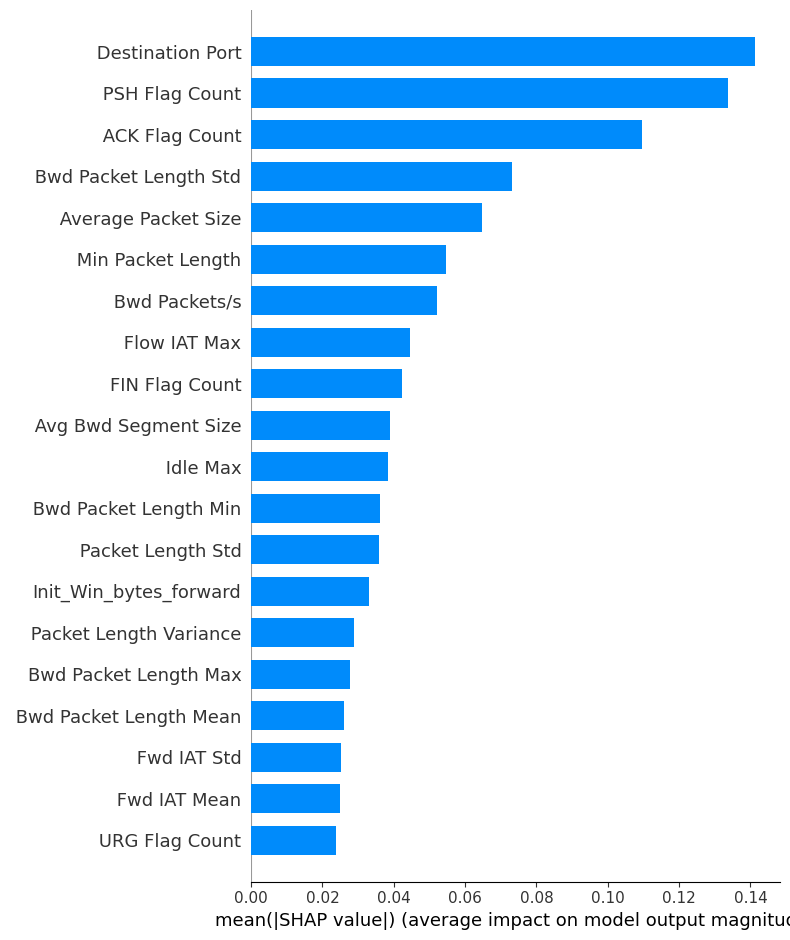

In [14]:
print(f"Shap values shape: {shap_values.shape}")
print(f"Malicious classes shape: {malicious_classes.shape}")

malicious_shape_values = shap_values[malicious_classes]
print(f"Malicious shape values shape: {malicious_shape_values.shape}")
shap.summary_plot(malicious_shape_values, X_train, plot_type="bar")


--- 

# Adversarial Explanations

## Load Adversarial Data Samples

In [15]:
# load adversarial sample
X_test_adv_fgsm = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_adv_fgsm_proto.csv")
#X_test_adv_cw = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_small_adv_cw.csv")
X_test_adv_hsj = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_adv_hsj_proto.csv")

## Check Performance

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy without attack: {accuracy * 100:.2f}%')

loss_adv_fgsm, accuracy_adv_fgsm = model.evaluate(X_test_adv_fgsm, y_test)
print(f'Accuracy on fgsm attack: {accuracy_adv_fgsm * 100:.2f}%')

#loss_adv_cw, accuracy_adv_cw = model.evaluate(X_test_adv_cw, y_test)
#print(f'Accuracy on cw attack: {accuracy_adv_cw * 100:.2f}%')

loss_adv_hsj, accuracy_adv_hop_skip_jump = model.evaluate(X_test_adv_hsj, y_test)
print(f'Accuracy on hop_skip_jump attack: {accuracy_adv_hop_skip_jump * 100:.2f}%')

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9798 - loss: 0.0483 
Accuracy without attack: 98.20%
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7691 - loss: 377.8260  
Accuracy on fgsm attack: 76.55%
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8243 - loss: 0.8233  
Accuracy on hop_skip_jump attack: 80.95%


## Generate Explanations on Adversarial Data

In [17]:
# FGSM Attack
adv_explainer_fgsm = shap.Explainer(model, X_test_adv_fgsm, feature_names=X_test_adv_fgsm.columns)
adv_shap_values_fgsm = adv_explainer_fgsm(X_test_adv_fgsm)
print(adv_shap_values_fgsm.shape)

# CW Attack
#adv_explainer_cw = shap.Explainer(model, X_test_adv_cw, feature_names=X_test_adv_cw.columns)
#adv_shap_values_cw = adv_explainer_cw(X_test_adv_cw)
#print(adv_shap_values_cw.shape)

# Hop-Skip-Jump Attack
adv_explainer_hsj = shap.Explainer(model, X_test_adv_hsj, feature_names=X_test_adv_hsj.columns)
adv_shap_values_hsj = adv_explainer_hsj(X_test_adv_hsj)
print(adv_shap_values_hsj.shape)

PermutationExplainer explainer: 2001it [01:33, 19.06it/s]                          


(2000, 70, 2)


PermutationExplainer explainer: 2001it [01:43, 17.39it/s]                          

(2000, 70, 2)


In [18]:
# convert shap values to correct format
print("Convert FGSM shap values...")
print(adv_shap_values_fgsm.shape) # one shap value per feature per sample per class
adv_shap_values_fgsm = adv_shap_values_fgsm[:, :, 0] # 1 == Benign, 0 == Malicious
print(adv_shap_values_fgsm.shape) # one shap value per feature per sample

#print("Convert CW shap values...")
#print(adv_shap_values_cw.shape) # one shap value per feature per sample per class
#adv_shap_values_cw = adv_shap_values_cw[:, :, 0] # 1 == Benign, 0 == Malicious
#print(adv_shap_values_cw.shape) # one shap value per feature

print("Convert Hop-Skip-Jump shap values...")
print(adv_shap_values_hsj.shape) # one shap value per feature per sample per class
adv_shap_values_hsj = adv_shap_values_hsj[:, :, 0] # 1 == Benign, 0 == Malicious
print(adv_shap_values_hsj.shape) # one shap value per feature per sample

Convert FGSM shap values...
(2000, 70, 2)
(2000, 70)
Convert Hop-Skip-Jump shap values...
(2000, 70, 2)
(2000, 70)


## Store Adversarial Explanations

In [19]:
adv_shap_values_fgsm_df = pd.DataFrame(adv_shap_values_fgsm.values, columns=feature_names)
#adv_shap_values_cw_df = pd.DataFrame(adv_shap_values_cw.values, columns=feature_names)
adv_shap_values_hop_skip_jump_df = pd.DataFrame(adv_shap_values_hsj.values, columns=feature_names)

adv_shap_values_fgsm_df.to_csv("../CICIDS2017/shap_values/adv_shap_values_fgsm_proto.csv", index=False)
#adv_shap_values_cw_df.to_csv("../CICIDS2017/shap_values/adv_shap_values_cw_small.csv", index=False)
adv_shap_values_hop_skip_jump_df.to_csv("../CICIDS2017/shap_values/adv_shap_values_hsj_proto.csv", index=False)

---
## Identifying Samples Misclassified Due to Adversarial Attacks

In [20]:
print("Correct Labels:")
y_test_np = np.array(y_test).argmin(axis=1)
print(f"Prediction: {y_test_np[:20]}")

# predict samples
print("Prediction on clean samples...")
y_pred = model.predict(X_test)
print("convert to binary...")
print(y_pred.shape)
y_pred = y_pred.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(y_pred.shape)
print(f"Prediction: {y_pred[:20]}")

print("Prediction on FGSM attacked samples...")
y_pred_adv_fgsm = model.predict(X_test_adv_fgsm)
y_pred_adv_fgsm = y_pred_adv_fgsm.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(f"Prediction: {y_pred_adv_fgsm[:20]}")

# print("Prediction on CW attacked samples...")
# y_pred_adv_cw = model.predict(X_test_adv_cw)
# y_pred_adv_cw = y_pred_adv_cw.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
# print(f"Prediction: {y_pred_adv_cw[:20]}")

print("Prediction on Hop Skip Jump attacked samples...")
y_pred_adv_hsj = model.predict(X_test_adv_hsj)
y_pred_adv_hsj = y_pred_adv_hsj.argmin(axis=1) # convert to binary, 1 == benign, 0 == malicious
print(f"Prediction: {y_pred_adv_hsj[:20]}")

Correct Labels:
Prediction: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1]
Prediction on clean samples...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
convert to binary...
(2000, 2)
(2000,)
Prediction: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1]
Prediction on FGSM attacked samples...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
Prediction: [1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
Prediction on Hop Skip Jump attacked samples...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [21]:
# find misclassified samples due to FGSM attack

# Find correctly classified indices
correctly_classified_indices = np.where(y_test_np == y_pred)[0]

# Find indices where attack misclassifies a `1` as `0`
false_negative_indices_fgsm = correctly_classified_indices[
    (y_test_np[correctly_classified_indices] == 1) & (y_pred_adv_fgsm[correctly_classified_indices] == 0)
]
print(f"FGSM: Misclassify Begnin Traffic as Malicious: {false_negative_indices_fgsm[:10]}")
print(f"Size: {np.size(false_negative_indices_fgsm)}")

# Find indices where attack misclassifies a `0` as `1`
false_positive_indices_fgsm = correctly_classified_indices[
    (y_test_np[correctly_classified_indices] == 0) & (y_pred_adv_fgsm[correctly_classified_indices] == 1)
]
print(f"FGSM: Misclassify Malicious Traffic as Benign: {false_positive_indices_fgsm[:10]}")
print(f"Size: {np.size(false_positive_indices_fgsm)}")

# all misclassified samples
misclassified_adversarial_indices = np.concat([false_negative_indices_fgsm, false_positive_indices_fgsm])
print(f"FGSM: All Missclassified Samples after Attack: {np.size(misclassified_adversarial_indices)}")

FGSM: Misclassify Begnin Traffic as Malicious: [  5  13  26  51  80 103 120 127 144 161]
Size: 97
FGSM: Misclassify Malicious Traffic as Benign: [ 9 14 15 20 31 40 61 70 71 78]
Size: 360
FGSM: All Missclassified Samples after Attack: 457


In [22]:
# # find misclassified samples due to CW attack

# # Find indices where attack misclassifies a `1` as `0`
# false_negative_indices_cw = correctly_classified_indices[
#     (y_test_np[correctly_classified_indices] == 1) & (y_pred_adv_cw[correctly_classified_indices] == 0)
# ]
# print(f"CW: Misclassify Begnin Traffic as Malicious: {false_negative_indices_cw[:10]}")
# print(f"Size: {np.size(false_negative_indices_cw)}")

# # Find indices where attack misclassifies a `0` as `1`
# false_positive_indices_cw = correctly_classified_indices[
#     (y_test_np[correctly_classified_indices] == 0) & (y_pred_adv_cw[correctly_classified_indices] == 1)
# ]
# print(f"CW: Misclassify Malicious Traffic as Benign: {false_positive_indices_cw[:10]}")
# print(f"Size: {np.size(false_positive_indices_cw)}")

# # all misclassified samples
# misclassified_adversarial_indices = np.concat([false_negative_indices_cw, false_positive_indices_cw])
# print(f"CW: All Missclassified Samples after Attack: {np.size(misclassified_adversarial_indices)}")

In [23]:
# find misclassified samples due to Hop Skip Jump attack

# Find indices where attack misclassifies a `1` as `0`
false_negative_indices_hsj = correctly_classified_indices[
    (y_test_np[correctly_classified_indices] == 1) & (y_pred_adv_hsj[correctly_classified_indices] == 0)
]
print(f"Hop Skip Jump: Misclassify Begnin Traffic as Malicious: {false_negative_indices_hsj[:10]}")
print(f"Size: {np.size(false_negative_indices_hsj)}")

# Find indices where attack misclassifies a `0` as `1`
false_positive_indices_hsj = correctly_classified_indices[
    (y_test_np[correctly_classified_indices] == 0) & (y_pred_adv_hsj[correctly_classified_indices] == 1)
]
print(f"Hop Skip Jump: Misclassify Malicious Traffic as Benign: {false_positive_indices_hsj[:10]}")
print(f"Size: {np.size(false_positive_indices_hsj)}")

# all misclassified samples
misclassified_adversarial_indices = np.concat([false_negative_indices_hsj, false_positive_indices_hsj])
print(f"Hop Skip Jump: All Missclassified Samples after Attack: {np.size(misclassified_adversarial_indices)}")

Hop Skip Jump: Misclassify Begnin Traffic as Malicious: []
Size: 0
Hop Skip Jump: Misclassify Malicious Traffic as Benign: [ 9 14 15 20 31 40 61 70 71 78]
Size: 368
Hop Skip Jump: All Missclassified Samples after Attack: 368


## Plot Sample Explanations that is Misclassified as Benign due to Attack

In [24]:
# find matching indices where FGSM and CW attack triggers misclassification of a malicious samples as benign
matching_indices = np.intersect1d(false_positive_indices_fgsm, false_positive_indices_hsj)
print(f"Matching indices: {matching_indices[:10]}")

Matching indices: [ 9 14 15 20 31 40 61 70 71 78]


### Correct Classified

Index: 9
Prediction: 0 | 0 == Malicious, 1 == Benign


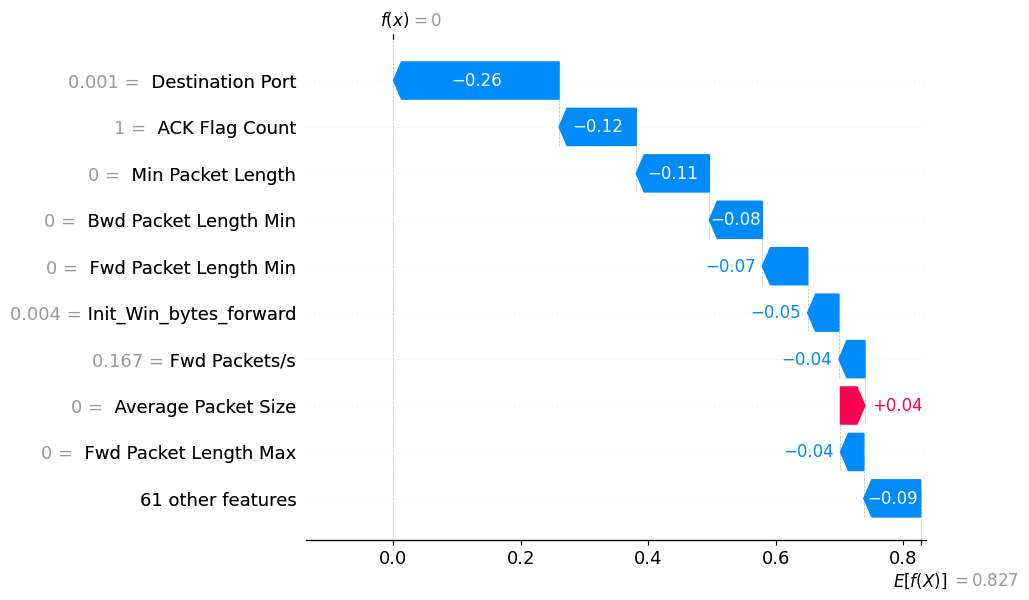

In [25]:
index = matching_indices[0]
print(f"Index: {index}")
print(f"Prediction: {y_pred[index]} | 0 == Malicious, 1 == Benign")


# plot explanation from correct classified samples
shap.waterfall_plot(shap_values[index])

### Misclassified due to Attack

Index: 9
Prediction: 1 | 0 == Malicious, 1 == Benign


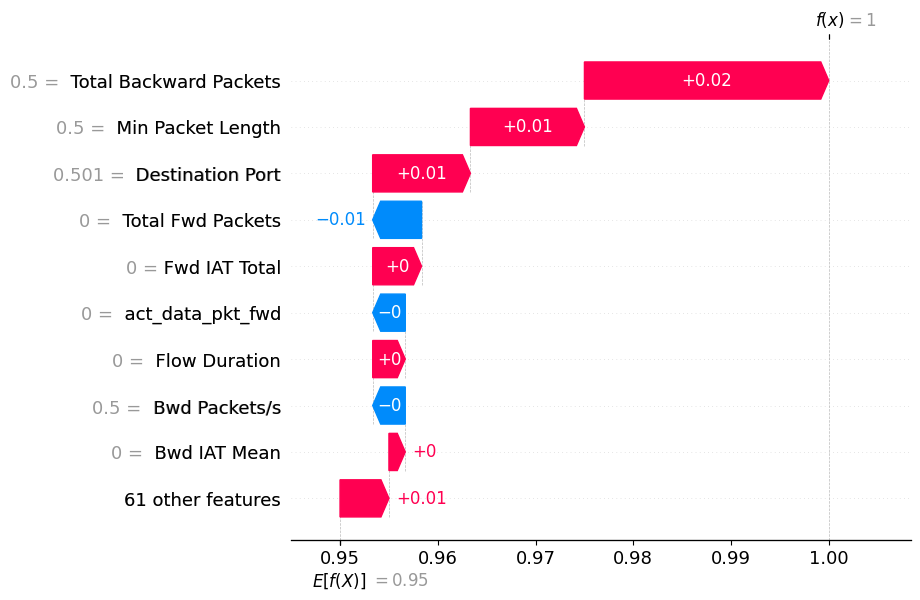

In [26]:
# FGSM attack
print(f"Index: {index}")
print(f"Prediction: {y_pred_adv_fgsm[index]} | 0 == Malicious, 1 == Benign")

# plot explanations from misclassified samples
shap.waterfall_plot(adv_shap_values_fgsm[index])

Index: 9
Prediction: 1 | 0 == Malicious, 1 == Benign


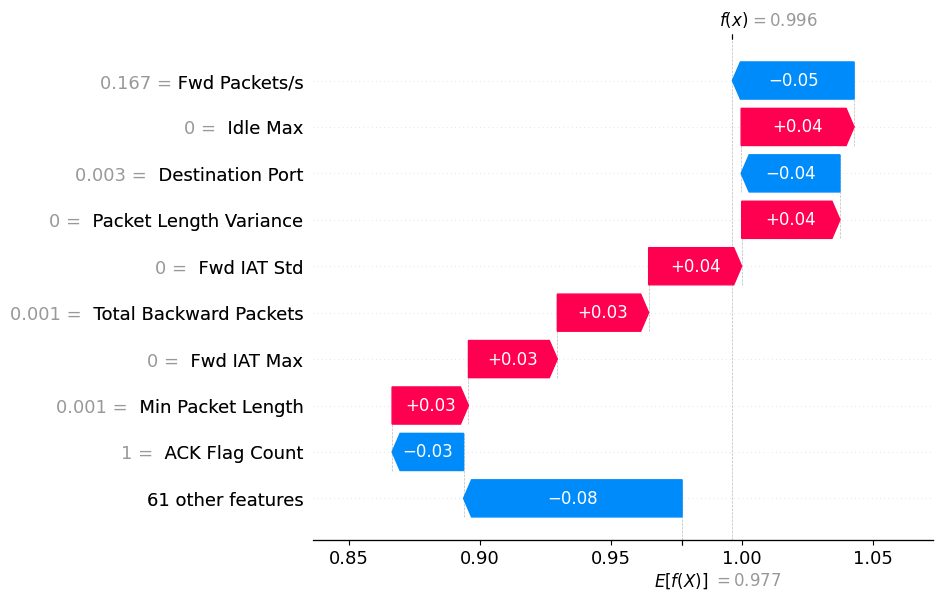

In [27]:
# Hop Skip Jump attack
print(f"Index: {index}")
print(f"Prediction: {y_pred_adv_hsj[index]} | 0 == Malicious, 1 == Benign")

# plot explanations from misclassified samples
shap.waterfall_plot(adv_shap_values_hsj[index])

In [28]:
# # CW attack
# print(f"Index: {index}")
# print(f"Prediction: {y_pred_adv_cw[index]} | 0 == Malicious, 1 == Benign")

# # plot explanations from misclassified samples
# shap.waterfall_plot(adv_shap_values_cw[index])

## ***Finding***: *Features with the highest SHAP Values are different! -> Explanation do not match to prediction!*

## Compare Values

In [29]:
local_fgsm_df = X_test_adv_fgsm.iloc[index]
#print(local_fgsm_df.to_string())

In [30]:
local_cw_df = X_test_adv_hsj.iloc[index]
#print(local_cw_df.to_string())

In [31]:
local_df = X_test.iloc[index]
#print(local_df.to_string())

## Global SHAP Distribution of Attacked System

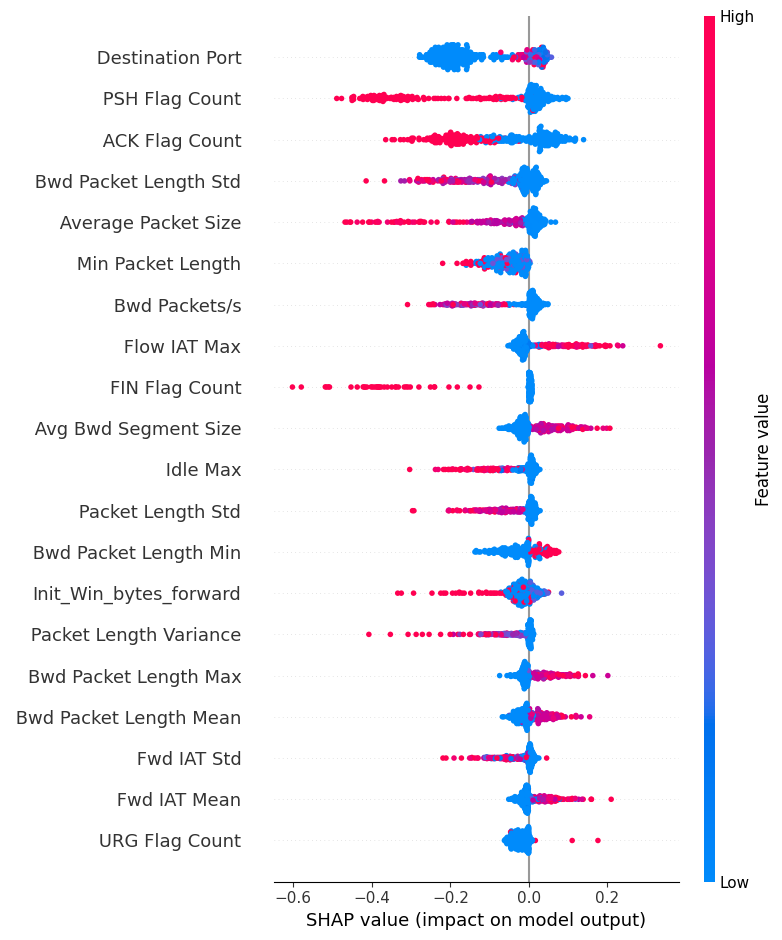

In [32]:
# plot normal
X_test_np = np.array(X_test)
shap.summary_plot(shap_values[false_positive_indices_fgsm], X_test_np[false_positive_indices_fgsm])

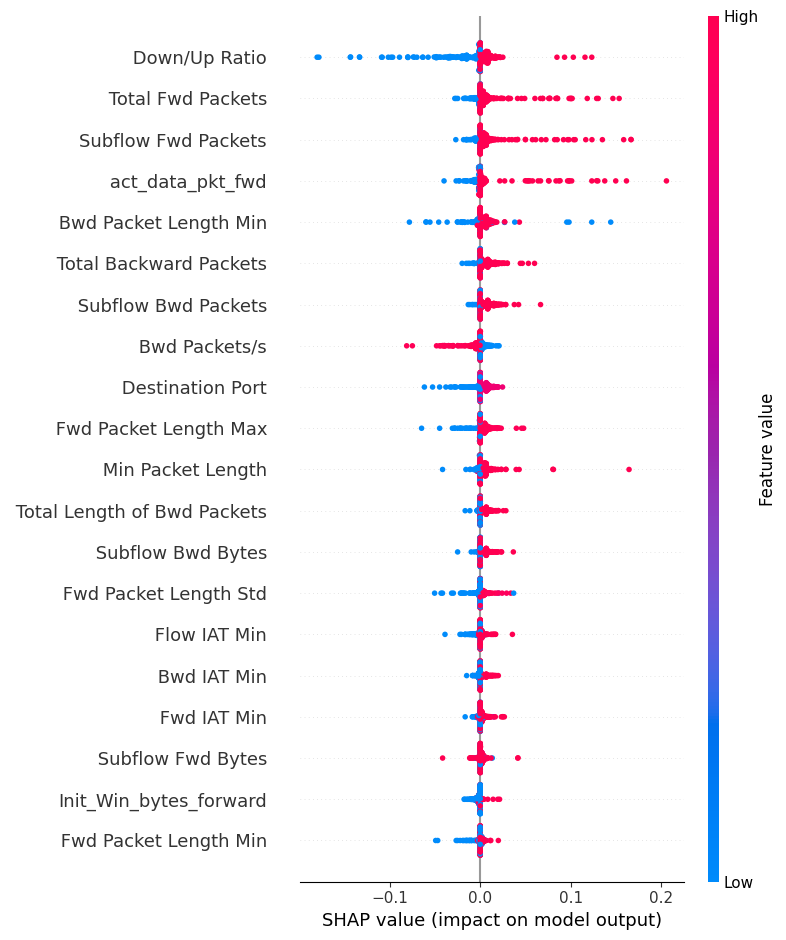

In [33]:
# plot FGSM attack
X_test_adv_fgsm_np = np.array(X_test_adv_fgsm)
shap.summary_plot(adv_shap_values_fgsm[false_positive_indices_fgsm], X_test_adv_fgsm_np[false_positive_indices_fgsm])

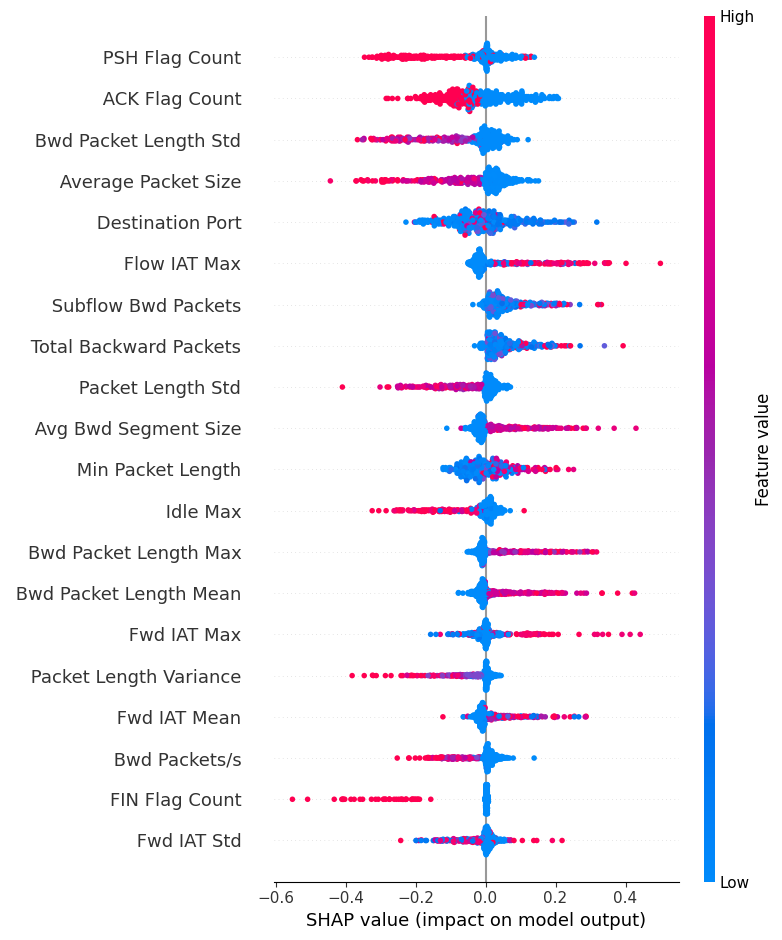

In [34]:
# plot HSJ attack
X_test_adv_hsj_np = np.array(X_test_adv_hsj)
shap.summary_plot(adv_shap_values_hsj[false_positive_indices_hsj], X_test_adv_hsj_np[false_positive_indices_hsj])

## Global Plot of Benign Samples

[ 0  1  2  3  4  6  7  8  9 10]


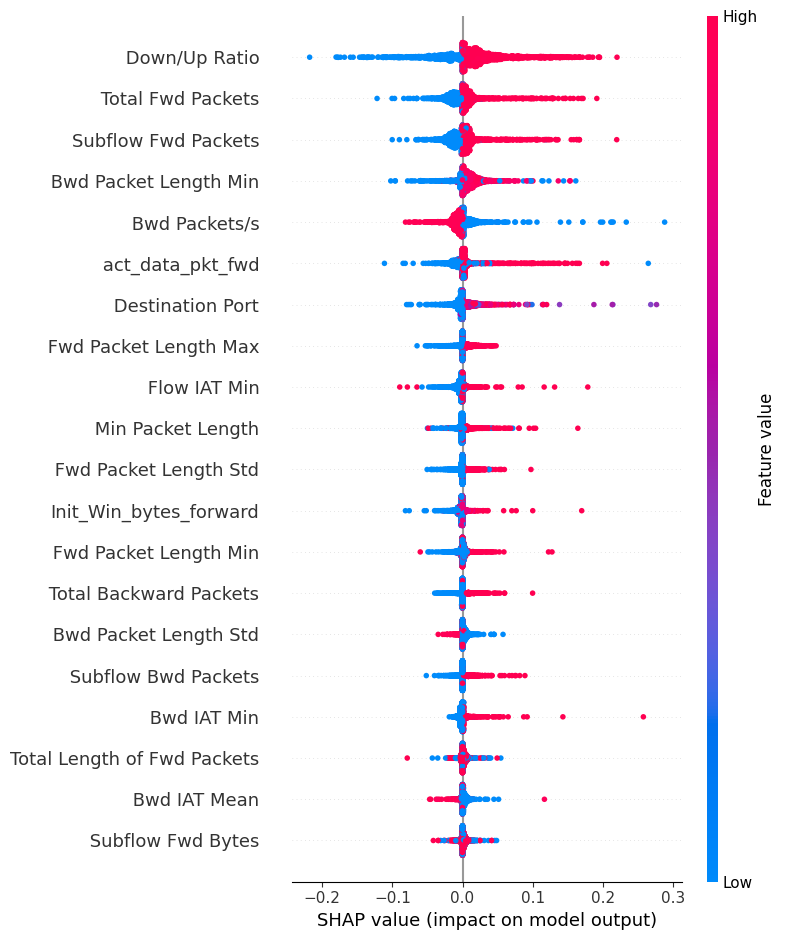

In [35]:
# get benign classes from FGSM attack
benign_classes_fgsm = np.where(y_pred_adv_fgsm == 1)[0]
print(benign_classes_fgsm[:10])

shap.summary_plot(adv_shap_values_fgsm[benign_classes_fgsm], X_test_adv_fgsm.iloc[benign_classes_fgsm])

[0 1 2 3 4 5 6 7 8 9]


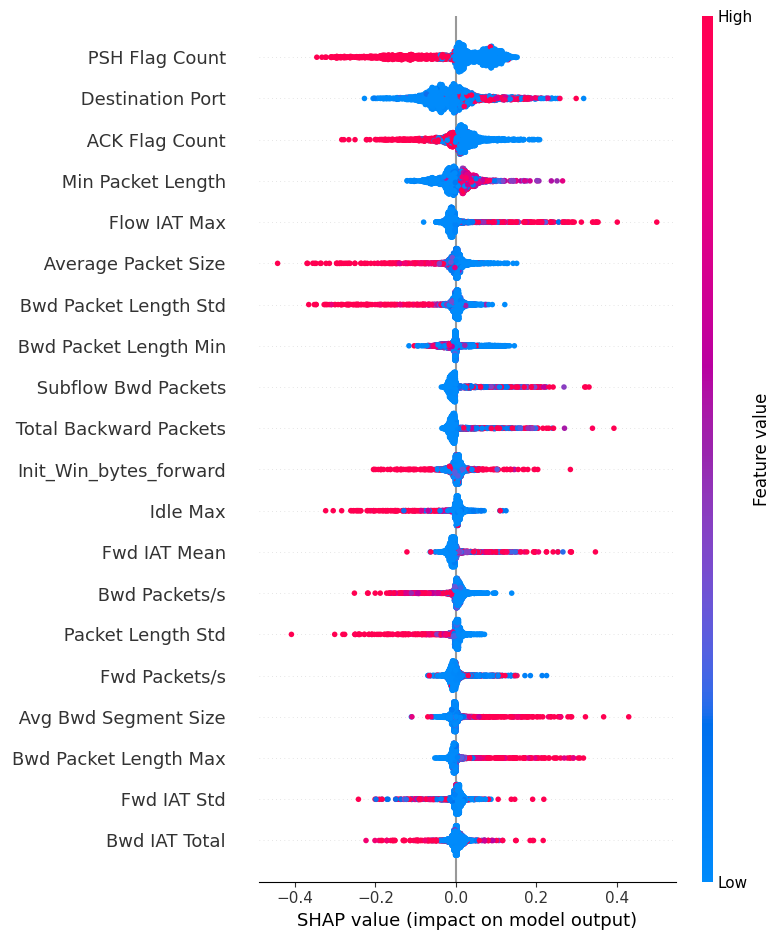

In [38]:
# get benign classes from HSJ attack
benign_classes_hsj = np.where(y_pred_adv_hsj == 1)[0]
print(benign_classes_hsj[:10])

shap.summary_plot(adv_shap_values_hsj[benign_classes_hsj], X_test_adv_hsj.iloc[benign_classes_hsj])

[ 0  1  2  3  4  5  6  7  8 10]


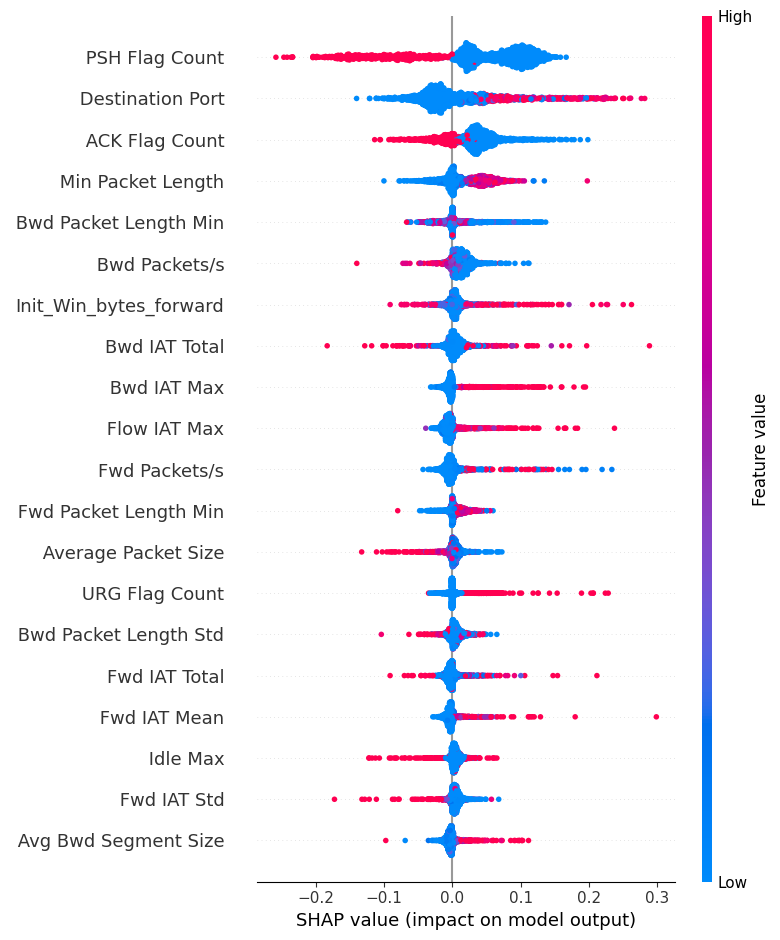

In [37]:
# get benign classes from normal prediction
benign_classes = np.where(y_pred == 1)[0]
print(benign_classes[:10])

shap.summary_plot(shap_values[benign_classes], X_test.iloc[benign_classes])